# Encoders

In [ ]:
%%capture
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

In [ ]:
def Encoder(x,w):
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1)))
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1)))
    x = x.view(x.size(0), 6272)
    x = linear(x,w[2])
    return x

In [ ]:
def Decoder(x,w):
    x = linear(x,w[3])
    x = x.view(x.size(0), 128, 7, 7)
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1)))
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1)))
    return x

In [ ]:
def Autoencoder(x,w):
    return Decoder(Encoder(x,w),w)

In [ ]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [ ]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

In [ ]:
def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [ ]:
num_epochs = 10
batch_size = 512
learning_rate = 1e-3

In [ ]:
img_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def MSE(image_batch_recon, image_batch):
    return torch.mean((image_batch_recon - image_batch)**2)

In [ ]:
#Encode
w0 = GPU(randn_trunc((64,1,4,4)))
w1 = GPU(randn_trunc((128,64,4,4)))
w2 = GPU(randn_trunc((10,6272)))
#Decode
w3 = GPU(randn_trunc((6272,10)))
w4 = GPU(randn_trunc((128,64,4,4)))
w5 = GPU(randn_trunc((64,1,4,4)))

w = [w0,w1,w2,w3,w4,w5]

optimizer = torch.optim.Adam(params=w, lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):

    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = Autoencoder(image_batch,w)
        
        # reconstruction error
        loss = MSE(image_batch_recon, image_batch)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
    print(loss.item())


0.16077370941638947
0.10883702337741852
0.09959464520215988
0.0975675880908966
0.08258278667926788
0.08043438196182251
0.07297738641500473
0.0767812505364418
0.07788223028182983
0.07612445205450058


In [ ]:
test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:    
    with torch.no_grad():
        image_batch = image_batch.to(device)
        image_batch_recon = Autoencoder(image_batch,w)
        loss = F.mse_loss(image_batch_recon, image_batch)
        test_loss_avg += loss.item()
        num_batches += 1
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.070931


In [ ]:
images, labels = iter(test_dataloader).next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


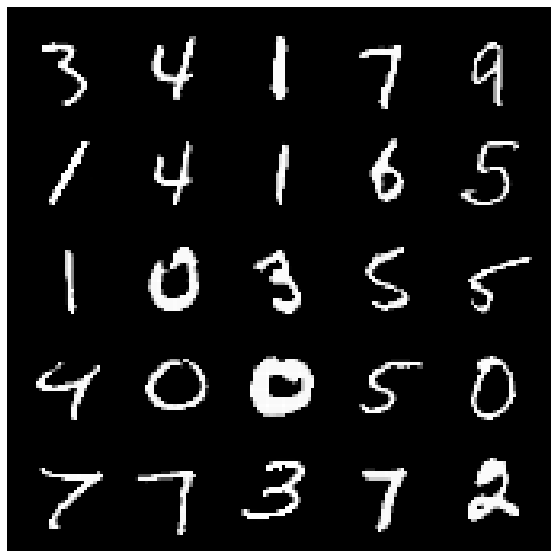

In [ ]:
plot(np.transpose(torchvision.utils.make_grid(images[:25], 5, 5).detach().numpy(), (1, 2, 0)))

In [ ]:
images = images.to(device)
images = Autoencoder(images,w)
images = images.cpu()
images = to_img(images)

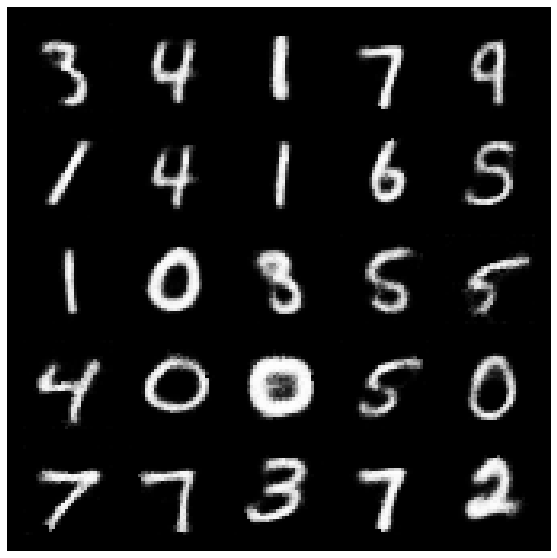

In [ ]:
plot(np.transpose(torchvision.utils.make_grid(images[:25], 5, 5).detach().numpy(), (1, 2, 0)))

#Embedding

In [ ]:
images = images.to(device)
code = Encoder(images,w).detach().cpu().numpy()

In [ ]:
code.shape

(512, 2)

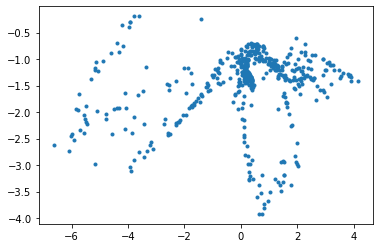

In [ ]:
plt.plot(code[:,0],code[:,1],'.')

In [ ]:
images, labels = iter(test_dataloader).next()

In [ ]:
x = images
y = labels

In [ ]:
j = 0

In [ ]:
k = [torch.where(y == j)[0].cpu().numpy() for j in range(10)]

In [ ]:
x[k[0]].shape

torch.Size([52, 1, 28, 28])

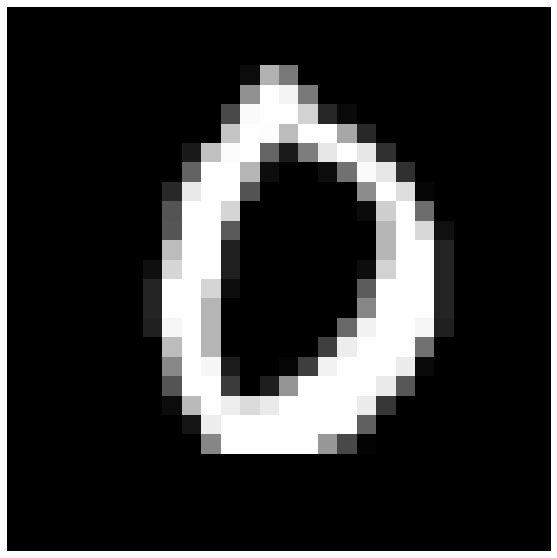

In [ ]:
plot(x[k[0][0],0,:,:].cpu().numpy())

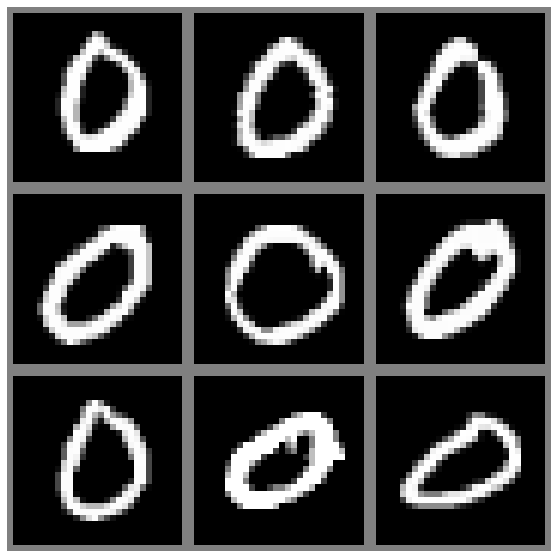

In [ ]:
montage_plot(x[k[0][0:9],0,:,:].cpu().numpy())

In [ ]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [ ]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [ ]:
x0 = x[k[0][0:],:,:,:].to(device)
x1 = x[k[1][0:],:,:,:].to(device)
x2 = x[k[2][0:],:,:,:].to(device)
x3 = x[k[3][0:],:,:,:].to(device)

In [ ]:
x0.shape

torch.Size([52, 1, 28, 28])

In [ ]:
code0 = Encoder(x0,w).detach().cpu().numpy()
code1 = Encoder(x1,w).detach().cpu().numpy()
code2 = Encoder(x2,w).detach().cpu().numpy()
code3 = Encoder(x3,w).detach().cpu().numpy()

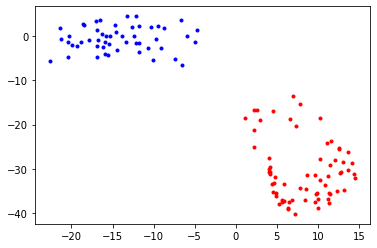

In [ ]:
plt.plot(code0[:,0],code0[:,1],'b.')
plt.plot(code1[:,0],code1[:,1],'r.')
# plt.plot(code2[:,0],code2[:,1],'g.')
# plt.plot(code3[:,0],code3[:,1],'m.')